<a href="https://colab.research.google.com/github/yhetman/hackathon_2021/blob/imartsilenko/Clarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
#download libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import cv2
import urllib
import urllib.request

In [102]:
# edges
def edges(n, orient):
    edges = np.ones((2*n, 2*n, 3))
    
    if orient == 'vert':
        for i in range(0, 2*n):
            edges[i][n: 2*n] *= -1
    elif orient == 'horiz':
        edges[n: 2*n] *= -1
    
    return edges

In [103]:
# Apply one filter defined by parameters W and single slice
def conv_single_step(a_slice_prev, W):
    s = W * a_slice_prev
    Z = np.sum(s)
    Z = np.abs(Z)
    
    return Z

In [104]:
# Full edge filter
def conv_forward(A_prev, W, hparameters):
    m = len(A_prev)
    (f, f, n_C) = W.shape
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    Z = list()
    flag = 0
    z_max = hparameters['z_max']
    
    if len(z_max) == 0:
        z_max = list()
        flag = 1
    
    for i in range(m):
        
        (x0, x1, x2) = A_prev[i].shape
        A_prev_pad = A_prev[i][ 
                            int(x0 / 3) : int(x0 * 2 / 3), 
                            int(x1 / 3) : int(x1 * 2 / 3), 
                            :]
        
        (n_H_prev, n_W_prev, n_C_prev) = A_prev_pad.shape
        n_H = int((n_H_prev - f + 2*pad) / stride) + 1
        n_W = int((n_W_prev - f + 2*pad) / stride) + 1
        z = np.zeros((n_H, n_W))
        
        a_prev_pad = A_prev_pad
        
        for h in range(n_H):
            vert_start = h * stride
            vert_end = h * stride + f
            
            for w in range(n_W):
                horiz_start = w * stride
                horiz_end = w * stride + f
                
               
                a_slice_prev = a_prev_pad[vert_start: vert_end, horiz_start: horiz_end, :]

                weights = W[:, :, :]
                z[h, w] = conv_single_step(a_slice_prev, weights)
        
        if flag == 1:
            z_max.append(np.max(z))
        Z.append(z / z_max[i])
        
    cache = (A_prev, W, hparameters)
    
    return Z, z_max, cache

In [105]:
# pooling
def pool_forward(A_prev, hparameters, mode = 'max'):
    m = len(A_prev)
    f = hparameters['f']
    stride = hparameters['stride']
    
    A = list()
    
    for i in range(m):
        (n_H_prev, n_W_prev) = A_prev[i].shape
        
        n_H = int(1 + (n_H_prev - f) / stride)
        n_W = int(1 + (n_W_prev - f) / stride)
        
        a = np.zeros((n_H, n_W))
        
        for h in range(n_H):
            vert_start = h * stride
            vert_end = h * stride + f
            
            for w in range(n_W):
                horiz_start = w * stride
                horiz_end = w * stride + f
                
                a_prev_slice = A_prev[i][vert_start: vert_end, horiz_start: horiz_end]

                if mode == 'max':
                    a[h, w] = np.max(a_prev_slice)
                elif mode == 'avg':
                    a[h, w] = np.mean(a_prev_slice)
                        
        A.append(a)

    cache = (A_prev, hparameters)
    
    return A, cache

In [106]:
# main layer
def borders(images, filter_size = 1, pad = 0, stride = 1, pool_stride = 2, pool_size = 2, z_max = []):
    Wv = edges(filter_size, 'vert')
    hparameters = {'pad': pad, 'stride': stride, 'pool_stride': pool_stride, 'f': pool_size, 'z_max': z_max}
    Z, z_max_v, _ = conv_forward(images, Wv, hparameters)
    
    print('edge filter applied')
    
    hparameters_pool = {'stride': pool_stride, 'f': pool_size}
    Av, _ = pool_forward(Z, hparameters_pool, mode = 'max')
    
    print('vertical filter applied')
    
    Wh = edges(filter_size, 'horiz')
    hparameters = {'pad': pad, 'stride': stride, 'pool_stride': pool_stride, 'f': pool_size, 'z_max': z_max}
    Z, z_max_h, _ = conv_forward(images, Wh, hparameters)
    
    print('edge filter applied')
    
    hparameters_pool = {'stride': pool_stride, 'f': pool_size}
    Ah, _ = pool_forward(Z, hparameters_pool, mode = 'max')
    
    print('horizontal filter applied')   
    
    return [(Av[i] + Ah[i]) / 2 for i in range(len(Av))], list(map(np.max, zip(z_max_v, z_max_h)))

In [107]:
#download images from hard disk
def download(directory = 'C:\\'):
    start_time = time.time()

    img_names = os.listdir(directory)[500:600]
    images = list()
    for img in img_names:
        images.append(plt.imread(directory + img))

    len(images)

    print("--- %s seconds ---" % (time.time() - start_time))
    
    return img_names, images

In [108]:
# calculate borders of original and blurred images
def orig_blur(images, filter_size = 1, stride = 3, pool_stride = 2, pool_size = 2, blur = 57):
    z_max = []

    img, z_max = borders(images, 
                         filter_size = filter_size, 
                         stride = stride, 
                         pool_stride = pool_stride, 
                         pool_size = pool_size
                        )
    print('original image borders is calculated')
    
    blurred_img = [cv2.GaussianBlur(x, (blur, blur), 0) for x in images]
    print('images blurred')
    
    blurred, z_max = borders(blurred_img, 
                             filter_size = filter_size, 
                             stride = stride, 
                             pool_stride = pool_stride, 
                             pool_size = pool_size, 
                             z_max = z_max
                            )
    print('blurred image borders is calculated')

    return [np.mean(orig) / np.mean(blurred) for (orig, blurred) in zip(img, blurred)], img, blurred

In [109]:
#img_names, images = download()

In [110]:
# download images from url
def url_to_image(url):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    scale_percent = 100 # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)

    image = cv2.resize(image, dim)
    # return the image
    return image

In [111]:
# examples
list_images_url = [#совсем мыло
                   'https://image.freepik.com/free-photo/fashion-shopping_47840-463.jpg',
                   'https://t3.ftcdn.net/jpg/04/12/04/00/240_F_412040016_X6JIZpfNEQciDf5aNegXwNhNz3ZBhYu5.jpg',
                   'https://t3.ftcdn.net/jpg/01/38/61/34/240_F_138613490_WkkxQY1MolsWDen0AwDU7EyiGhOtiMN4.jpg',
                   'https://t4.ftcdn.net/jpg/03/02/97/87/240_F_302978766_ZEJPQBeMI37wfcb41gidVl3p5Q4Pdxv3.jpg', 
                   'https://t3.ftcdn.net/jpg/04/11/10/20/240_F_411102030_ZVDyXI9Cj7m8VotDzHHrWaaaEMVouI7K.jpg',

                    # просто размытые 
                   'https://image.freepik.com/free-photo/_1203-8782.jpg',
                   'https://as1.ftcdn.net/v2/jpg/01/02/72/62/1000_F_102726270_8aa6ZImtjHrmmBGhlPOZ7p6lOC2nAhg8.jpg',
                   'https://as1.ftcdn.net/v2/jpg/00/99/61/32/1000_F_99613293_dYykb7pMc51zoLmR5ISEs3WXaQoDQ6ht.jpg',
                   'https://t3.ftcdn.net/jpg/01/66/42/20/240_F_166422008_ejLnM5fo8gYjB9sV8swcckv2hpSmLCLq.jpg',



                   #фотки норм но специфические 
                   'https://t4.ftcdn.net/jpg/04/23/28/95/240_F_423289521_deNlRtSeEtegWeK9b1VQp4WePnuFWMA0.jpg',
                   'https://t4.ftcdn.net/jpg/04/39/07/33/240_F_439073364_9lEqBUXc5qKEJ9ZzTsGv0171NDwkDg4C.jpg',

                    #четкие
                   'https://image.freepik.com/free-photo/3d_105762-935.jpg',
                   'https://as2.ftcdn.net/v2/jpg/03/92/03/93/1000_F_392039386_5wZMoriWbZ3JYtWDozJLZm1FlTELtfQp.jpg',
                   'https://image.freepik.com/free-photo/_1161-231.jpg',
                   'https://t3.ftcdn.net/jpg/02/14/57/68/240_F_214576821_3DqK9qg0ZpaDyFLdULBlZGSUHMuIw3qq.jpg',
                   'https://t4.ftcdn.net/jpg/03/67/33/37/240_F_367333779_48XlJK23abK1NXHYHmnwBOS2Uha7JQLD.jpg',
                   'https://t3.ftcdn.net/jpg/04/13/21/52/240_F_413215241_DPPfQ1m79KLLup5AgO14mbxTP0zPCR1F.jpg',
                   'https://t4.ftcdn.net/jpg/01/01/30/31/240_F_101303147_7beIIowDZG69Fu29KHJpeT9fk7Rht99q.jpg',
                    'https://t3.ftcdn.net/jpg/02/67/61/94/240_F_267619489_PC6b2vLxPRG8dopYNTYugoKxcLtIK9lZ.jpg',
                   'https://t3.ftcdn.net/jpg/03/69/49/32/240_F_369493257_7wA6P8hUbwRcuBv2WgkwnNo1glEHXesU.jpg',
                    'https://t4.ftcdn.net/jpg/04/09/65/71/240_F_409657181_sRsNzbmI5xdHyVMWvx1zFis0Z9ECXpYG.jpg',


                  ]

list_images = list(map(url_to_image, list_images_url))

In [112]:
k, i, b = orig_blur(list_images, filter_size = 1, stride = 1)

edge filter applied
vertical filter applied
edge filter applied
horizontal filter applied
original image borders is calculated
images blurred
edge filter applied
vertical filter applied
edge filter applied
horizontal filter applied
blurred image borders is calculated


In [113]:
k

[2.706036254320477,
 3.2343981356844793,
 4.609450604499191,
 4.539145003623266,
 3.4435773889528933,
 8.452264230150275,
 12.148057831186202,
 7.670939661811389,
 4.358879068275666,
 11.176493194190925,
 6.939170053388872,
 12.039399229562676,
 22.62266608043184,
 14.087398847806462,
 84.1125925925926,
 9.104871350359158,
 16.313581567265782,
 7.083462003980738,
 15.927227171664864,
 16.14091022488328,
 14.396911665825842]

Получается, что если меньше 8 то размытенько, 
А меньше 5 совсем мыло, остальное годное.

In [114]:
fig, axs = plt.subplots(5, 3, figsize=(200, 180))

for n in range(5): 

  axs[n, 0].set_title(k[n])
  axs[n, 0].imshow(list_images[n])

  axs[n, 1].set_title("Orig")
  axs[n, 1].imshow(i[n])

  axs[n, 2].set_title("Blur")
  axs[n, 2].imshow(b[n])

plt.imshow(i[10])

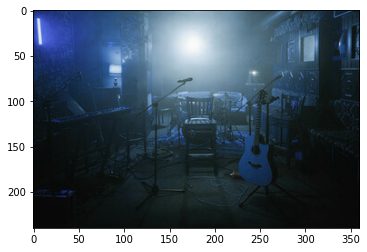

In [118]:
plt.imshow(list_images[19])

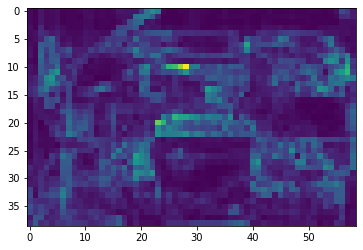

In [119]:
plt.imshow(i[19])

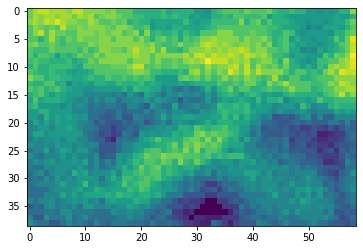

In [120]:
plt.imshow(b[19])